`sdg4varselect` depends on `jax` library but also from `parametrization_cookbook`, this is not mandatory but strongly recommended all the examples will use a specific parametrization.

Let's start by importing all dependencies and the package :

In [1]:
import numpy as np
import jax.numpy as jnp
import jax.random as jrd

import parametrization_cookbook.jax as pc

import sdg4varselect.plotting as sdgplt
from sdg4varselect.outputs import MultiGDResults

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


### Mixed Effects Model Specification

First, let's define the model with the abstract object AbstractMixedEffectsModel. We want to define the following logisitc models :

$$ \left\{\begin{array}{rll}
            Y_{i,j} &= m(t_{i,j}; \varphi_i) + \varepsilon_{i,j}
            \\ \varphi_i \sim \mathcal N(\mu, \Gamma)   
            & ; ~\varepsilon_{i,j} \sim \mathcal N(0,\sigma^2).             
        \end{array}\right. ~ \forall i \in\{1,...,N\}, j\in\{1,...,J\}$$

where : $$m(t_{i,j}; \varphi_i) = \frac{\varphi_{1,i}}{1+\exp\left(\frac{\varphi_{2,i}-t_{i,j}}{\tau} \right)}$$


#### Python implementation of the Model

First let define the non-linear function m of our model !

In [2]:
def m(
    params, times: jnp.ndarray, phi1: jnp.ndarray, phi2: jnp.ndarray, **kwargs
) -> jnp.ndarray:
    """logistic_curve

    Parameters
    ----------
    params : object
        parameter array containing tau the growth rate
    times : jnp.ndarray(shape = (N,J))
        observation times
    phi1 : jnp.ndarray(shape = (N,))
        asymptotic value
    phi2 : jnp.ndarray(shape = (N,))
        inflexion point
    """

    out = phi1[:, None] / (1 + jnp.exp(-(times - phi2[:, None]) / params.tau))
    assert out.shape == times.shape
    return out

We can now define our models as follows. We define a new python class inherited from the `AbstractMixedEffectsModel` class. This implements the minimal structure to define a model from only the function that we have just implemented.

We also want to define a high dimensional covariate model, we inherit from the `AbstractHDModel` class for this.

In [3]:
import functools
from jax import jit

from sdg4varselect.models.abstract.abstract_mixed_effects_model import (
    AbstractMixedEffectsModel,
)


class LogisticMixedEffectsModel(AbstractMixedEffectsModel):
    """define a logistic mixed effects model"""

    def __init__(self, N=1, J=1, **kwargs):
        super().__init__(N=N, J=J, me_name=["phi1", "phi2"], **kwargs)

    def init_parametrization(self):
        self._parametrization = pc.NamedTuple(
            mean_latent=pc.RealPositive(shape=(2,), scale=(100, 2000)),
            cov_latent=pc.MatrixDiagPosDef(dim=2, scale=(100, 2000)),
            tau=pc.RealPositive(scale=100),
            var_residual=pc.RealPositive(scale=100),
        )

    @property
    def name(self):
        return f"tutorial_logi_MEM_N{self.N}_J{self.J}"

    # ============================================================== #
    @functools.partial(jit, static_argnums=0)
    def mixed_effect_function(self, params, *args, **kwargs) -> jnp.ndarray:
        return m(params, *args, **kwargs)

    # ============================================================== #

    def sample(self, params_star, prngkey, **kwargs):
        prngkey_time, prngkey_mem = jrd.split(prngkey, num=2)

        # === nlmem_simulation() === #
        time = jnp.linspace(100, 1800, self.J)
        time = jnp.tile(time, (self.N, 1))
        time += 10 * jrd.uniform(prngkey_time, minval=-2, maxval=2, shape=time.shape)

        obs, sim = AbstractMixedEffectsModel.sample(
            self, params_star, prngkey_mem, mem_obs_time=time
        )

        return {"mem_obs_time": time} | obs, sim

### Data Generation
Then we can generate a data set with $N=200$ individuals and $J=15$ observation time per individuals and $P = 10$ covariates

In [2]:

parametrization = pc.Tuple(
     pc.RealPositive(),
     pc.Real(shape=(2,3)),
     pc.MatrixSymPosDef(dim=3),
 )
parametrization.size

AttributeError: 'Tuple' object has no attribute 'size'

In [1]:
import parametrization_cookbook.jax as pc

parametrization = pc.NamedTuple(
     mu=pc.Real(shape=3),
     Sigma=pc.MatrixSymPosDef(dim=3),
     df=pc.RealPositive()
)
parametrization.size


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


AttributeError: 'NamedTuple' object has no attribute 'size'

Text(0, 0.5, 'Logistic growth')

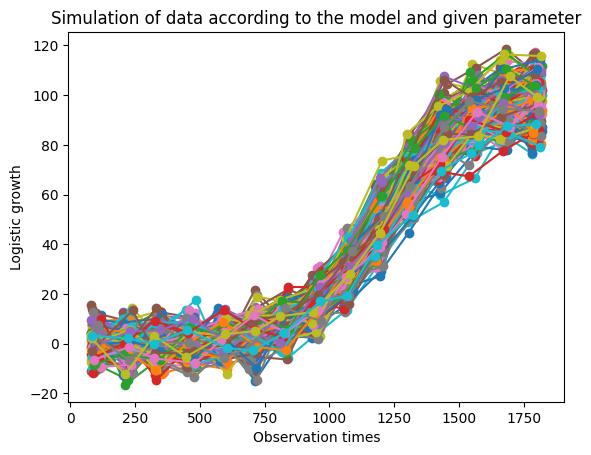

In [4]:
import matplotlib.pyplot as plt

myModel = LogisticMixedEffectsModel(N=200, J=15)

p_star = myModel.new_params(
    mean_latent=jnp.array([100, 1200]),
    cov_latent=jnp.diag(jnp.array([50, 1000])),
    tau=150,
    var_residual=30,
)

myobs, mysim = myModel.sample(p_star, jrd.PRNGKey(0))

ax = plt.figure().add_subplot(1, 1, 1)
_ = ax.plot(myobs["mem_obs_time"].T, myobs["Y"].T, "o-")
ax.set_title("Simulation of data according to the model and given parameter")
ax.set_xlabel("Observation times")
ax.set_ylabel("Logistic growth")

# Estimation example

Let's do an estimation of the parameter with the SGD-FIM algorithm

In order to compute the `StochasticProximalGradientDescentFIM` (`SPGD_FIM`) we must define an preconditionner. We use in this example the Fisher Information Matrix with the al ready implemented class `preconditionner.Fisher` !

Now let's define the algorithm and calculate the first estimate !

In [5]:
from sdg4varselect.algo.sto_grad_descent_precond import (
    StochasticGradientDescentPrecond as SGD_Prec,
)
import sdg4varselect.algo.preconditioner as preconditioner

FIM = preconditioner.Fisher()
algo = SGD_Prec(FIM)
algo.init_mcmc(myModel, sd={"phi1": 5, "phi2": 20})

# prngkey_theta, prngkey = jrd.split(jrd.PRNGKey(0))
# theta0 = 0.2 * jrd.normal(prngkey_theta, shape=(myModel.parametrization.size,))
# algo.set_seed(prngkey)
# res = algo.fit(myModel, myobs, theta0)

Before plotting the restults, let's cheking the iteration of the MCMC sampler :

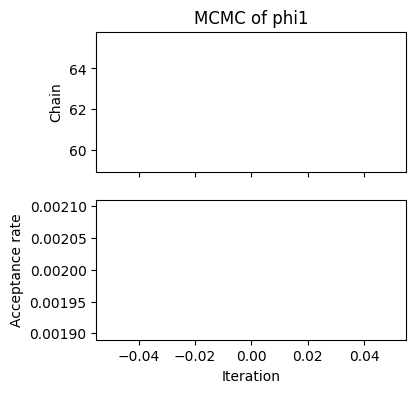

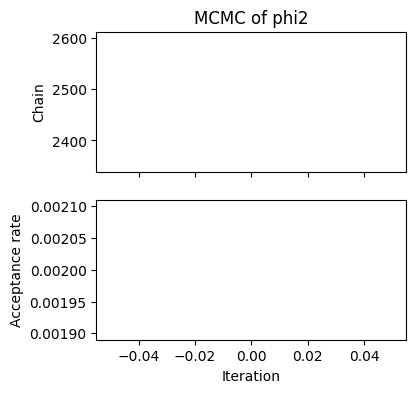

In [6]:
sdgplt.FIGSIZE = 4
_ = sdgplt.plot_mcmc(algo)

In [23]:
def one_estim(prngkey, model, data):
    prngkey_theta, prngkey = jrd.split(prngkey)
    theta0 = 0.2 * jrd.normal(prngkey_theta, shape=(model.parametrization.size,))
    algo.set_seed(prngkey)
    res = algo.fit(model, data, theta0)
    return res


multi_estim = MultiGDResults(
    [one_estim(jrd.PRNGKey(i), myModel, myobs) for i in range(4)]
)

In [24]:
multi_estim.chrono

datetime.timedelta(seconds=46, microseconds=874098)

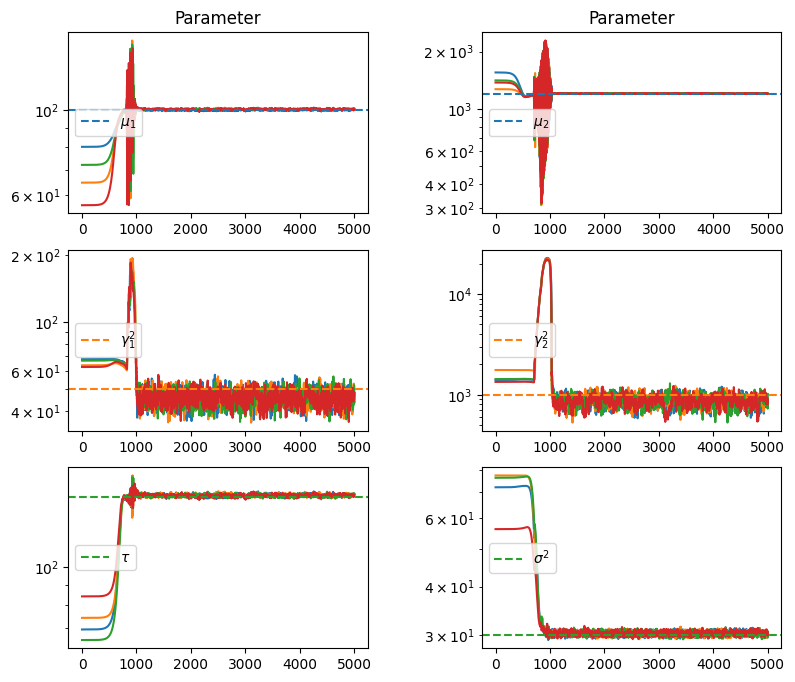

In [27]:
p_names = np.array(
    ["$\\mu_1$", "$\\mu_2$"]
    + ["$\\gamma^2_1$", "$\\gamma^2_{12}$", "$\\gamma^2_{21}$", "$\\gamma^2_2$"]
    + ["$\\tau$", "$\\sigma^2$"]
)

fig = sdgplt.figure(8, 8)
_ = sdgplt.plot_theta(
    multi_estim,
    fig=fig.subfigures(1, 2, wspace=0.07),
    params_star=p_star,
    params_names=p_names,
    id_to_plot=[[0, 2, 6], [1, 5, 7]],
)